In [1]:
import numpy as np
print(np.__version__)
from scipy.stats import multivariate_normal
import wfdb

from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
%matplotlib inline

1.24.0


In [2]:
from numba import njit

In [3]:
def awgn(sig, snr_db):
    """
    add white gaussian noise to the signal
    snr_db: signal to noise ratio (in dB)
    """
    sig_p = np.mean(sig**2)
    snr = 10 ** (snr_db / 10)  # dB = 10 log_10 (x)
    noise_p = sig_p / snr
    noise = np.random.normal(0, np.sqrt(noise_p), sig.shape)
    return sig + noise

In [4]:
def make_Pi(i, P, N):
    mat = np.zeros((P, N))
    for j in range(P):
        mat[j, (i+j)%N] = 1
    return mat

In [5]:
def get_patches(sig, P):
    N = len(sig)
    patches = []
    for i in range(N):
        patches.append(make_Pi(i, P, N) @ sig)
    return patches


In [6]:
def calc_snr(clean, noisy):
    return 10*np.log10(np.sum(clean ** 2)/np.sum((noisy - clean)**2))

In [7]:
rec104 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/104")
rec105 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/105")
rec115 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/115")


In [8]:
P = 30
patchset104 = get_patches(rec104.p_signal[:10800, 1], P=P)

In [9]:
K = 10
gmm = GaussianMixture(n_components=K)
gmm.fit(patchset104)


GaussianMixture(n_components=10)

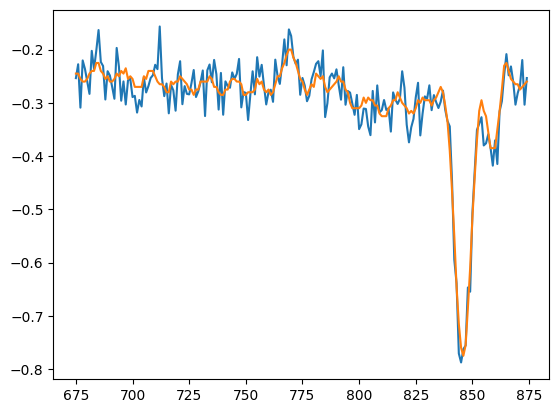

In [10]:
st = 675
N = 200
et = st+N
sig = rec115.p_signal[st:et, 1]
sign = awgn(sig, 20)
plt.plot(range(st, et), sign)
plt.plot(range(st, et), sig)


In [24]:
sigma2 = 1e-4
Pis = [make_Pi(i, P, N) for i in range(N)]
Cov1 = [gmm.covariances_[j] + sigma2 * np.eye(P) for j in range(K)]
Cs = [gmm.covariances_[j] @ np.linalg.inv(Cov1[j]) for j in range(K)]
alphas = gmm.weights_
Mu = gmm.means_
Nos = [multivariate_normal(mean=mu, cov=sigma).pdf for mu, sigma in zip(Mu, Cov1)]
def G(u):
    denom = sum((alphas[l] * Nos[l](u)) for l in range(K))
    return sum(((alphas[j] * Nos[j](u)) * Cs[j]) for j in range(K)) @ u/denom
def D(z):
    return 1/P * sum(Pis[i].T @ G(Pis[i] @ z) for i in range(N))

In [34]:
res = D(D(sign))

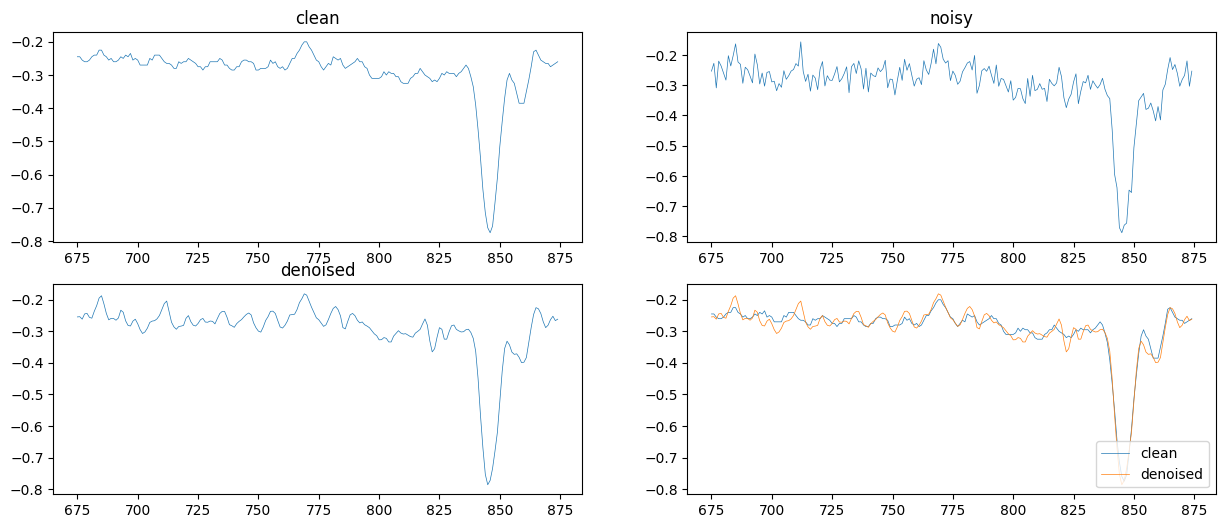

In [35]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15, 6)
ax1.plot(range(st, et), sig, linewidth=0.5)
ax1.set_title("clean")
ax2.plot(range(st, et), sign, linewidth=0.5)
ax2.set_title("noisy")
ax3.plot(range(st, et), res, linewidth=0.5)
ax3.set_title("denoised")
ax4.plot(range(st, et), sig, label="clean", linewidth=0.5)
# ax4.plot(range(st, et), sign, label="noisy", linewidth=0.5)
ax4.plot(range(st, et), res, label="denoised", linewidth=0.5)
ax4.legend(loc="lower right")

In [36]:
calc_snr(sig, sign)

20.28591214131319

In [37]:
calc_snr(sig, res)

24.12642832847165